### single label classification transformers


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
%matplotlib inline

# pytorch libraries
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from keras.preprocessing.sequence import pad_sequences
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Quadro RTX 6000'

In [2]:
#load train, test dataset
train_filename = "train_dropdups.csv"
val_filename = "validation_dropdups.csv"
test_filename = "test_dropdups.csv"

df_train = pd.read_csv(train_filename)
df_val = pd.read_csv(val_filename)
df_test = pd.read_csv(test_filename)

df_train

,TYPE,DOCUMENT_CONTENT,DOCUMENT_CLASS
0,TRAIN,Great News to All Vape Lovers Vapefanz has res...,2
1,TRAIN,Vaprcase 2 Review: Lifegrabber√¢‚Ç¨‚Ñ¢s Soluti...,1
2,TRAIN,i bought 2 boxes and both has 0.8 and 1.2,1
3,TRAIN,pod Fundamentals Explained vanilla - When rega...,1
4,TRAIN,Pretty fun time streaming some VALORANT with m...,2
...,...,...,...
4835,TRAIN,√¢≈° √Ø¬∏¬è√∞≈∏¬ê¬¢ TURTLE JUICE √∞≈∏¬ê¬¢√¢≈° ...,1
4836,TRAIN,Dude check out blankz pods. They make a Juul c...,1
4837,TRAIN,Koko prem vape device here√∞≈∏‚Äò‚Ä∞0562220852...,1
4838,TRAIN,Hero of the day myblu capsules We tell there a...,2


In [3]:
print('Unique content: ', df_train['DOCUMENT_CONTENT'].nunique() == df_train.shape[0])
print('Null values: ', df_train.isnull().values.any())
print('Average sentence length: ', df_train['DOCUMENT_CONTENT'].str.split().str.len().mean())
print('Std deviation sentence length: ', df_train['DOCUMENT_CONTENT'].str.split().str.len().std())

Unique content:  True
Null values:  False
Average sentence length:  36.20702479338843
Std deviation sentence length:  25.99536799296542


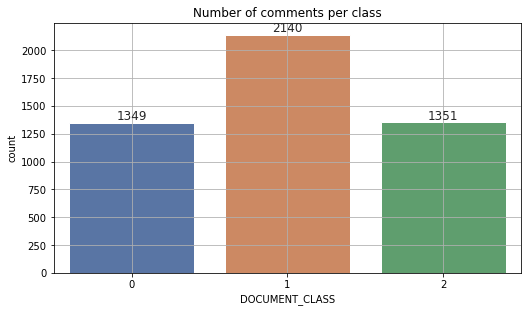

In [4]:
# make a frequency plot for each category

category_counts = {}
for doc_type in df_train['DOCUMENT_CLASS']:
    if doc_type not in category_counts.keys():
        category_counts[doc_type] = 1
    else:
        category_counts[doc_type] += 1

plt.rcParams["figure.figsize"] = [7.50, 4.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
# df_train['DOCUMENT_CLASS'].value_counts().plot(ax=ax, kind='bar')

sns.set(style="ticks")
ax = sns.countplot(x='DOCUMENT_CLASS', data=df_train)
ax.bar_label(ax.containers[0])
plt.title("Number of comments per class")
plt.grid()
plt.show()


In [5]:
# extract out data content column and labels
X_train = df_train["DOCUMENT_CONTENT"]
X_val = df_val["DOCUMENT_CONTENT"]
X_test = df_test["DOCUMENT_CONTENT"]
y_train = df_train["DOCUMENT_CLASS"].values
y_val = df_val["DOCUMENT_CLASS"].values
y_test = df_test["DOCUMENT_CLASS"].values

# seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

X_train.shape

(4840,)

In [6]:
# converting y into one hot vectors like multiclass

# encoded_dict = {‘0’:[1,0,0],’1’:[0,1,0], ‘2’:[0,0,1]}
num_classes = len(category_counts.keys())
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [7]:
# Clean data
def rm_non_ascii(text):
    # remeove non-ascii characters
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # remove digits and underscores
    text = re.sub(r'[0-9_:\-\'\"\[\]?/+=.,;!@#$%^&*()<>|{}~]+',' ', text)
    # removes mutiple spaces
    text = " ".join(text.split())
    return text

print("Sample X before cleaning:", X_train[1])
X_train = X_train.apply(rm_non_ascii)
X_val = X_val.apply(rm_non_ascii)
X_test = X_test.apply(rm_non_ascii)
print("Sample X after cleaning:", X_train[1])



Sample X before cleaning: Vaprcase 2 Review: Lifegrabber√¢‚Ç¨‚Ñ¢s Solution to Protect Pax 2 Vaporizers ...#cannabisnews #cannabis #hemp #CBD
Sample X after cleaning: Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD


In [8]:
# stemming to bring base word form. lemmatisation not req

def stemming(text):
    ps = PorterStemmer()

    words = word_tokenize(text)
    for i in range(len(words)):
        words[i] = ps.stem(words[i])
    text = " ".join(words)
    return text
        
print("Sample X before stemming:", X_train[1])    
# X_train = X_train.apply(stemming)
# X_val = X_val.apply(stemming)
# X_test = X_test.apply(stemming)
print("Sample X after stemming:", X_train[1])



Sample X before stemming: Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD
Sample X after stemming: Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD


In [9]:
def show_metrics(y_test, y_pred, title="Classifier"):
    # Calculate confusion matrix

    matrix=confusion_matrix(y_test, y_pred)
    cm_labeled=pd.DataFrame(matrix,index=['0','1','2'],columns=['0','1','2'])
    # True Labels in y-axis/rows. Precision = TP/(TP+FP)
#     print("Confusion Matrix:\n", cm_labeled)
    sns.heatmap(cm_labeled, annot=True)
    plt.show()

    # Get the accuracy
    print('\nAccuracy: {:.5f}\n'.format(accuracy_score(y_test, y_pred)))

    # Print the classification report
    print(f'Classification Report {title}:')
#     TODO fix target names dynamic
    print(classification_report(y_test, y_pred, target_names=['DOC_0', 'DOC_1', 'DOC_2']))
    return accuracy_score(y_test, y_pred)

In [10]:
X_train = X_train.tolist()
X_val = X_val.values.tolist()
X_test = X_test.values.tolist()
len(X_train)

4840

In [11]:
# tokenizer converts sentence words into vector of fixed size numbers. Adding <Start> and <End> tag as well

max_length = 200
# TODO: or 100
# BERT tokenizer.
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# # XLNet tokenizer
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 
# # RoBERTa tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
# DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# MPNet
# tokenizer = MPNetTokenizer.from_pretrained("microsoft/mpnet-base")
# MiniLM
# tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-electra-base')
# DeBERTa
# tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
# DeBERTa v2
# tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v2-xlarge")
# Electra HF
# tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")
# Elctra Cross enocder
# tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-electra-base')

# tokenizer's encoding method
encodings_X_train = tokenizer.batch_encode_plus(X_train,max_length=max_length,pad_to_max_length=True, return_token_type_ids=True)
encodings_X_val = tokenizer.batch_encode_plus(X_val,max_length=max_length,pad_to_max_length=True, return_token_type_ids=True)
encodings_X_test = tokenizer.batch_encode_plus(X_test,max_length=max_length,pad_to_max_length=True, return_token_type_ids=True)

print('tokenizer outputs: ', encodings_X_train.keys())

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [12]:
# train tokenized embeddings and masks
input_ids_X_train = encodings_X_train['input_ids'] # tokenized and encoded sentences
token_type_ids_X_train = encodings_X_train['token_type_ids'] # token type ids
attention_masks_X_train = encodings_X_train['attention_mask'] # attention masks

# validation tokenized embeddings and masks
input_ids_X_val = encodings_X_val['input_ids']
token_type_ids_X_val = encodings_X_val['token_type_ids'] 
attention_masks_X_val = encodings_X_val['attention_mask'] 

# test tokenized embeddings and masks
input_ids_X_test = encodings_X_test['input_ids']
token_type_ids_X_test = encodings_X_test['token_type_ids'] 
attention_masks_X_test = encodings_X_test['attention_mask']


print(f"{X_train[1]}  \n{y_train[1]} --->\n\ninput encoding : {input_ids_X_train[1]}\ntoken type ids : {token_type_ids_X_train[1]}\nattention mask : {attention_masks_X_train[1]}")

Vaprcase Review Lifegrabber s Solution to Protect Pax Vaporizers cannabisnews cannabis hemp CBD  
[0. 1. 0.] --->

input encoding : [101, 12436, 18098, 18382, 3319, 2166, 17643, 29325, 1055, 5576, 2000, 4047, 6643, 2595, 20064, 17629, 2015, 17985, 2638, 9333, 17985, 19610, 2361, 17324, 2094, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
token type ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
# Select a batch size for training. For fine-tuning with XLNet, recommend a batch size of 32, 48, or 128.
batch_size = 32

# Convert all of our data into torch tensors
# train
input_ids_X_train = torch.tensor(input_ids_X_train)
attention_masks_X_train = torch.tensor(attention_masks_X_train)
y_train = torch.tensor(y_train)
token_type_ids_X_train = torch.tensor(token_type_ids_X_train)

# validation
input_ids_X_val = torch.tensor(input_ids_X_val)
attention_masks_X_val = torch.tensor(attention_masks_X_val)
y_val = torch.tensor(y_val)
token_type_ids_X_val = torch.tensor(token_type_ids_X_val)

# test
input_ids_X_test = torch.tensor(input_ids_X_test)
attention_masks_X_test = torch.tensor(attention_masks_X_test)
y_test = torch.tensor(y_test)
token_type_ids_X_test = torch.tensor(token_type_ids_X_test)


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, 
# unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory
train_data = TensorDataset(input_ids_X_train, attention_masks_X_train, y_train, token_type_ids_X_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(input_ids_X_val, attention_masks_X_val, y_val, token_type_ids_X_val)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create test dataloader
test_data = TensorDataset(input_ids_X_test, attention_masks_X_test, y_test, token_type_ids_X_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# save the dataloader
torch.save(train_dataloader,'train_data_loader')
torch.save(validation_dataloader,'validation_data_loader')
torch.save(test_dataloader,'test_data_loader')


/tmp/ipykernel_697/84025241.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_X_train = torch.tensor(input_ids_X_train)
/tmp/ipykernel_697/84025241.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks_X_train = torch.tensor(attention_masks_X_train)
/tmp/ipykernel_697/84025241.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
/tmp/ipykernel_697/84025241.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

In [19]:
# Load Model & Set Params

# (batch_size, epoch, accuracy)
# BERT (128,20, 0.801)
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)
# XLNet: (32, 12, 0.799)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_classes)
# RoBERTa: (64, 32, 0.8001)
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
# DistillBERT (128, 50, 0.7994)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)
# MPNet (128,6,0.81010)
# model = MPNetForSequenceClassification.from_pretrained("microsoft/mpnet-base", num_labels=num_classes)
# MiniLM (48, 16, 0.8028)
# model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-MiniLM-L-12-v2',ignore_mismatched_sizes=True, num_labels=num_classes)
# deBERTa (32, 36, 0.8185)
# model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=num_classes)
# deBERTa v2
# model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v2-xlarge", num_labels=num_classes)
# Electra HF(128, 16, 0.8004)
# model = ElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion", ignore_mismatched_sizes=True, num_labels=num_classes)
# Electra Cross encoder (64, 16, 0.80889)
# model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-electra-base', ignore_mismatched_sizes=True, num_labels=num_classes)

model.cuda()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-b

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [20]:
# setting custom optimization parameters. may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
# print("named parameters: ", param_optimizer)
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [21]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True, )
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimizat

### Train Model

In [22]:
# use “Binary Cross Entropy With Logits” as our loss function

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_classes),b_labels.type_as(logits).view(-1,num_classes)) #convert labels to float for calculation
#     loss_func = BCELoss() 
#     loss_func = CrossEntropyLoss() 
#     loss = loss_func(torch.sigmoid(logits.view(-1,num_classes)),b_labels.type_as(logits).view(-1,num_classes)) #convert labels to float for calculation
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
#   pred_bools = [pl>threshold for pl in pred_labels]
#   true_bools = [tl==1 for tl in true_labels]
  pred_bools = [np.argmax(pl, axis=0) for pl in pred_labels]    
  true_bools = [np.argmax(pl, axis=0) for pl in true_labels]

  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.65 GiB total capacity; 10.57 GiB already allocated; 6.44 MiB free; 10.64 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# loss_func(logits.view(-1,num_classes),b_labels.type_as(logits).view(-1,num_classes)) #convert labels to float for calculation
# logits.view(-1, num_classes)
# b_labels

In [ ]:
# import os
# output_dir = 'model_save'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# model_path = os.path.join(os.getcwd(), output_dir, 'deberta_model_slc')

# ## for loading back
# # model = model_class.from_pretrained(output_dir)


# torch.save(model.state_dict(), model_path)

# # current accuracy =0.8185 deberta

### Test Model and Get Metrics

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds, true_labels, pred_labels, tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
# Converting flattened binary values to boolean values
# true_bools = [tl==1 for tl in true_labels]
# pred_bools = [pl>0.60 for pl in pred_labels] #boolean output after thresholding

# get back single value labels from one-hot encoding
y_pred = [np.argmax(pl, axis=0) for pl in pred_labels]
y_testl = [np.argmax(pl, axis=0) for pl in true_labels]

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(y_testl, y_pred,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(y_testl, y_pred),'\n')
clf_report = classification_report(y_testl,y_pred,target_names=['0','1','2'])

pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

In [ ]:
pred_labels[:4]

In [ ]:
len(y_testl)

In [ ]:
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything

In [ ]:

def training_step(self, batch, batch_idx):
    labels = batch["label"]
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    token_type_ids = batch["token_type_ids"]

    loss, _ = self.model(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            labels=labels
            )

    tqdm_dict = {"train_loss": loss}
    output = OrderedDict({
        "loss": loss,
        "progress_bar": tqdm_dict,
        "log": tqdm_dict
        })

    return output

In [ ]:
def configure_optimizers(self):
    param_optimizer = list(self.model.named_parameters())
    no_decay = ["bias", "gamma", "beta"]
    optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.01
                },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.0
                },
            ]
    optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=2e-5,
            )
    return optimizer